<a href="https://colab.research.google.com/github/riadibadulla/CIFAR100-Experiments/blob/main/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.cuda.empty_cache()
import gc
gc.collect()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Resize(40),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

train_set, val_set = torch.utils.data.random_split(trainset, [40000, 10000])

validationloader = torch.utils.data.DataLoader(val_set, batch_size=32,
                                          shuffle=True, num_workers=2)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',' bowl',' boy',' bridge',' bus',' butterfly',' camel',
          ' can',' castle',' caterpillar',' cattle',' chair',' chimpanzee',' clock',' cloud',' cockroach',' couch',' cra',' crocodile',' cup',' dinosaur',' dolphin',
          ' elephant',' flatfish',' forest',' fox',' girl',' hamster',' house',' kangaroo',' keyboard',' lamp',' lawn_mower',' leopard',' lion',' lizard',' lobster',' man',
          ' maple_tree',' motorcycle',' mountain',' mouse',' mushroom',' oak_tree',' orange',' orchid',' otter',' palm_tree',' pear',' pickup_truck',' pine_tree',' plain',' plate',
          ' poppy',' porcupine',' possum',' rabbit',' raccoon',' ray',' road',' rocket',' rose',' sea',' seal',' shark',' shrew',' skunk',' skyscraper',
          'snail',' snake',' spider',' squirrel',' streetcar',' sunflower',' sweet_pepper',' table',' tank',' telephone',' television',
          ' tiger',' tractor',' train',' trout',' tulip',' turtle',' wardrobe',' whale',' willow_tree',' wolf',' woman',' worm')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


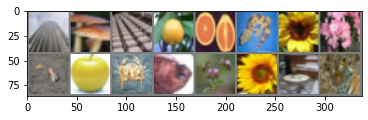

tensor([76, 51, 39, 53, 53, 44, 82, 70, 26,  0, 26, 32,  6, 82, 84, 88])
 skyscraper  mushroom  keyboard  orange  orange  lizard  sunflower  rose  cra  apple  cra   flatfish bee    sunflower  table  tiger


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

valiter = iter(validationloader)
val_images,val_labels = valiter.next()



val_images, val_labels = val_images.to(device), val_labels.to(device)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

My Custom Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3,64)
        self.conv2 = conv_block(64,128,pool=True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))
        self.conv3 = conv_block(128,256,pool=True)
        self.conv4 = conv_block(256,512,pool=True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))
        self.conv5 = conv_block(512,1028,pool=True)
        self.res3 = nn.Sequential(conv_block(1028,1028), conv_block(1028,1028))
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1028, 100))


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)+x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x)+x
        x = self.conv5(x)
        x = self.res3(x)+x
        x = self.classifier(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net.to(device)
criterion.to(device)

CrossEntropyLoss()

## **Transfer Learning**

ResNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Lastlayers(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,100)
        

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

net = torchvision.models.resnet18(pretrained=True)
net.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)
for i, param in enumerate(net.parameters()):
    if i==0:
      continue
    param.requires_grad = False

num_ftrs = net.fc.in_features
print(num_ftrs)
net.fc = Lastlayers()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# print(net)
net.to(device)
criterion.to(device)

512


CrossEntropyLoss()

VGG11

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Lastlayers(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4608,512)
        self.fc2 = nn.Linear(512,100)
        

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

net = torchvision.models.vgg11(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
print(net)
net.avgpool = nn.AdaptiveAvgPool2d((3, 3))
net.classifier = Lastlayers()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(net)
net.to(device)
criterion.to(device)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

CrossEntropyLoss()

In [ ]:
PATH = './cifar_net.pth'
for epoch in range(50):  # loop over the dataset multiple times
    best_val_loss = 10000
    running_loss = 0.0
    running_accuarcy = 0
    val_loss = 0
    val_acc = 0
    correct = 0
    total = 0
    total_val = 0
    correct_val = 0
    for i, data in enumerate(trainloader, 0):
        
        
        # get the inputs; data is a list of [inputs, labels]
        net.train()
        inputs, labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        with torch.no_grad():
          running_loss = loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          running_accuarcy = 100 * correct // total
        del inputs, labels

    for val_data in validationloader:
      with torch.no_grad():
        val_images, val_labels = val_data
        val_images,val_labels = val_images.to(device), val_labels.to(device)
        #calculate validation
        # val_images, val_labels = val_images.to(device), val_labels.to(device)
        net.eval()
        y_pred = net(val_images)
        val_loss = criterion(y_pred, val_labels).to(device)
        _, val_predicted_label = torch.max(y_pred.data, 1)
        correct_val += (val_predicted_label == val_labels).sum().item()
        total_val += val_labels.size(0)
    val_acc = 100 * correct_val // total_val
    
    print(f'Epoch{epoch + 1}:      loss: {running_loss:.3f} accuaracy: {running_accuarcy}% val_loss: {val_loss} val_acc: {val_acc}')
    if val_loss<best_val_loss:
      torch.save(net.state_dict(), PATH)
print('Finished Training')



Epoch1:      loss: 2.736 accuaracy: 17% val_loss: 3.3510992527008057 val_acc: 27
Epoch2:      loss: 3.221 accuaracy: 35% val_loss: 3.0199146270751953 val_acc: 38
Epoch3:      loss: 1.349 accuaracy: 46% val_loss: 1.6280455589294434 val_acc: 46
Epoch4:      loss: 1.391 accuaracy: 54% val_loss: 0.911482572555542 val_acc: 49
Epoch5:      loss: 1.419 accuaracy: 60% val_loss: 1.960017204284668 val_acc: 51
Epoch6:      loss: 1.422 accuaracy: 67% val_loss: 2.608015298843384 val_acc: 52
Epoch7:      loss: 0.879 accuaracy: 73% val_loss: 0.7259517312049866 val_acc: 54
Epoch8:      loss: 0.719 accuaracy: 79% val_loss: 1.233097791671753 val_acc: 55
Epoch9:      loss: 0.216 accuaracy: 84% val_loss: 2.3353028297424316 val_acc: 56
Epoch10:      loss: 0.114 accuaracy: 89% val_loss: 1.4551959037780762 val_acc: 58
Epoch11:      loss: 0.491 accuaracy: 92% val_loss: 4.164843559265137 val_acc: 58
Epoch12:      loss: 0.142 accuaracy: 94% val_loss: 1.3545653820037842 val_acc: 59
Epoch13:      loss: 0.083 accu

KeyboardInterrupt: ignored

Test

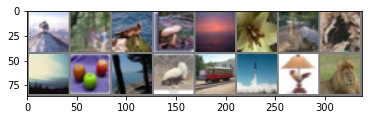

GroundTruth:   mountain  forest  seal  mushroom
Predicted:   train  forest  dolphin  mushroom
Accuracy of the network on the 10000 test images: 62 %
Accuracy for class: apple is 86.0 %
Accuracy for class: aquarium_fish is 74.0 %
Accuracy for class: baby  is 45.0 %
Accuracy for class: bear  is 45.0 %
Accuracy for class: beaver is 44.0 %
Accuracy for class: bed   is 64.0 %
Accuracy for class: bee   is 73.0 %
Accuracy for class: beetle is 62.0 %
Accuracy for class: bicycle is 72.0 %
Accuracy for class: bottle is 75.0 %
Accuracy for class:  bowl is 39.0 %
Accuracy for class:  boy  is 43.0 %
Accuracy for class:  bridge is 65.0 %
Accuracy for class:  bus  is 50.0 %
Accuracy for class:  butterfly is 55.0 %
Accuracy for class:  camel is 64.0 %
Accuracy for class:  can  is 65.0 %
Accuracy for class:  castle is 81.0 %
Accuracy for class:  caterpillar is 50.0 %
Accuracy for class:  cattle is 53.0 %
Accuracy for class:  chair is 81.0 %
Accuracy for class:  chimpanzee is 80.0 %
Accuracy for class: 

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')